In [157]:
import pandas as pd
import numpy as np
import yfinance as yf

import openai
import pandas as pd
from dotenv import load_dotenv
import os
import tqdm

import time

from curl_cffi import requests
session = requests.Session(impersonate="chrome")

import cvxpy as cp

from concurrent.futures import ThreadPoolExecutor, as_completed

In [6]:
choices = [15, 30, 45, 60]

In [ ]:
dotenv_path = os.path.join(os.path.dirname(os.getcwd()), '.env')
load_dotenv(dotenv_path)

def get_chatgpt_tickers(n):
    client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    message = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n} stocks (mention their tickers) from the S&P500 with the goal to outperform the S&P500 index. Return as a list that can be parsed in python."
    
    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": message}]
    )
    
    return response.choices[0].message.content

# Loop through each value and make 10 requests
with open(os.path.join("..", "data/chatgpt_tickers.txt"), "w") as f:
    for n in choices:
        for i in range(10):
            result = get_chatgpt_tickers(n)
            f.write(f"\n=== N={n} | Request {i+1} ===\n")
            f.write(result + "\n")
            print(f"[✔] Saved N={n}, Request {i+1}")
            time.sleep(1) 

[✔] Saved N=15, Request 1
[✔] Saved N=15, Request 2
[✔] Saved N=15, Request 3
[✔] Saved N=15, Request 4
[✔] Saved N=15, Request 5
[✔] Saved N=15, Request 6
[✔] Saved N=15, Request 7
[✔] Saved N=15, Request 8
[✔] Saved N=15, Request 9
[✔] Saved N=15, Request 10
[✔] Saved N=30, Request 1
[✔] Saved N=30, Request 2
[✔] Saved N=30, Request 3
[✔] Saved N=30, Request 4
[✔] Saved N=30, Request 5
[✔] Saved N=30, Request 6
[✔] Saved N=30, Request 7
[✔] Saved N=30, Request 8
[✔] Saved N=30, Request 9
[✔] Saved N=30, Request 10
[✔] Saved N=45, Request 1
[✔] Saved N=45, Request 2
[✔] Saved N=45, Request 3
[✔] Saved N=45, Request 4
[✔] Saved N=45, Request 5
[✔] Saved N=45, Request 6
[✔] Saved N=45, Request 7
[✔] Saved N=45, Request 8
[✔] Saved N=45, Request 9
[✔] Saved N=45, Request 10
[✔] Saved N=60, Request 1
[✔] Saved N=60, Request 2
[✔] Saved N=60, Request 3
[✔] Saved N=60, Request 4
[✔] Saved N=60, Request 5
[✔] Saved N=60, Request 6
[✔] Saved N=60, Request 7
[✔] Saved N=60, Request 8
[✔] Saved

In [3]:
import ast

def extract_all_ticker_lists(filepath):
    request_blocks = {}
    current_key = None
    inside_list = False
    buffer = []

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()

            # Detect a request header line
            if line.startswith("==="):
                current_key = line.strip("= ").strip()
                inside_list = False
                buffer = []
                continue

            # Detect any opening of a list
            if "[" in line and not inside_list and current_key:
                inside_list = True
                buffer = [line[line.find("["):]]  # keep only from the first `[`
                continue

            # Collect lines until the list is closed
            if inside_list:
                buffer.append(line)
                if "]" in line:
                    inside_list = False
                    try:
                        full_text = "\n".join(buffer)
                        tickers = ast.literal_eval(full_text)
                        request_blocks[current_key] = tickers
                    except Exception as e:
                        print(f"⚠️ Failed to parse tickers for {current_key}: {e}")
                        print("Block was:\n", full_text)
                    buffer = []

    return request_blocks

data = extract_all_ticker_lists(os.path.join("..", "data/chatgpt_tickers.txt"))

In [4]:
df = pd.DataFrame([
    {
        "request": k,
        "n": int(k.split("|")[0].split("=")[1].strip()),
        "tickers": v,
        "count": len(v)
    }
    for k, v in data.items()
])

df_exploded = df.explode("tickers").rename(columns={"tickers": "ticker"})

# Preview
print(df.head())
print(df_exploded["ticker"].value_counts().head(10))

            request   n                                            tickers  \
0  N=15 | Request 1  15  [AAPL, MSFT, GOOGL, V, UNH, NVDA, AVGO, MA, LM...   
1  N=15 | Request 2  15  [MSFT, AAPL, NVDA, GOOGL, AMZN, V, JPM, LIN, U...   
2  N=15 | Request 3  15  [AAPL, MSFT, NVDA, GOOGL, AMZN, V, UNH, MA, CO...   
3  N=15 | Request 4  15  [MSFT, NVDA, AAPL, GOOGL, AMZN, LLY, UNH, META...   
4  N=15 | Request 5  15  [AAPL, MSFT, NVDA, GOOGL, AMZN, LLY, AVGO, V, ...   

   count  
0     15  
1     18  
2     15  
3     15  
4     15  
ticker
AAPL     39
UNH      39
COST     39
NVDA     39
MSFT     39
GOOGL    39
AMZN     37
AVGO     37
META     35
V        35
Name: count, dtype: int64


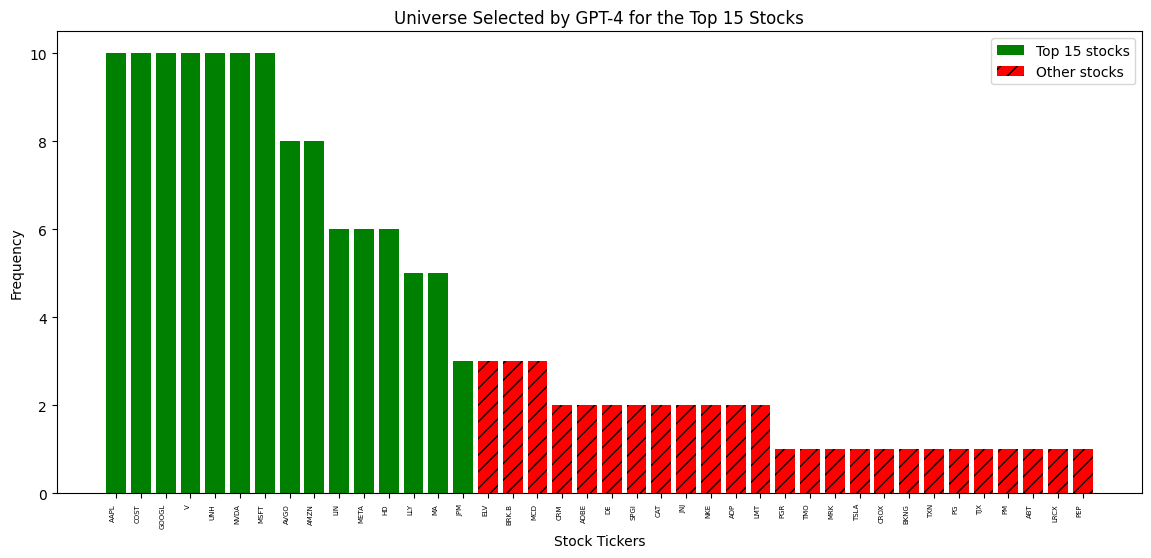

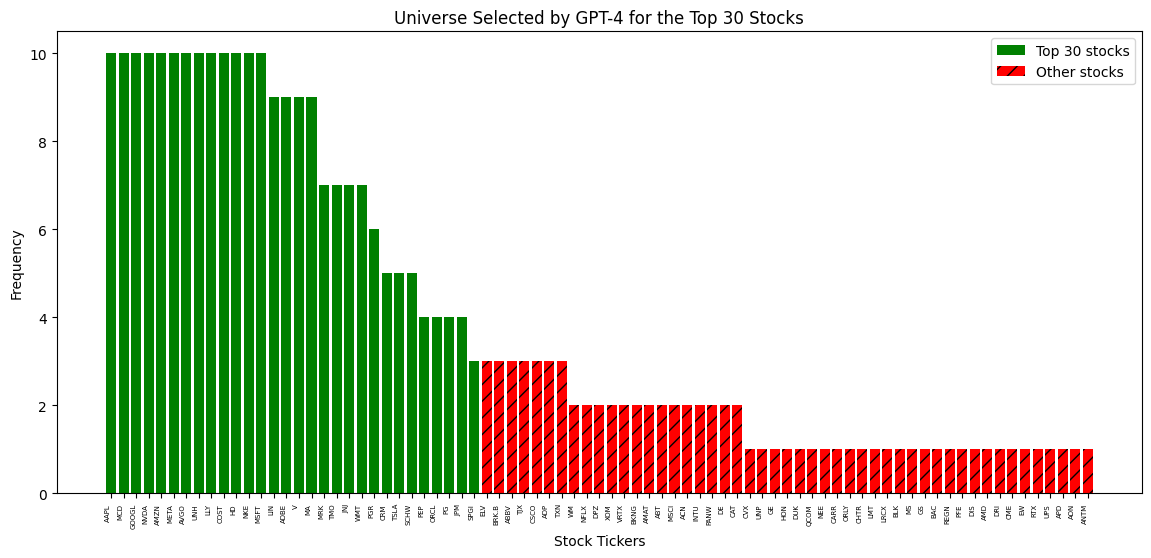

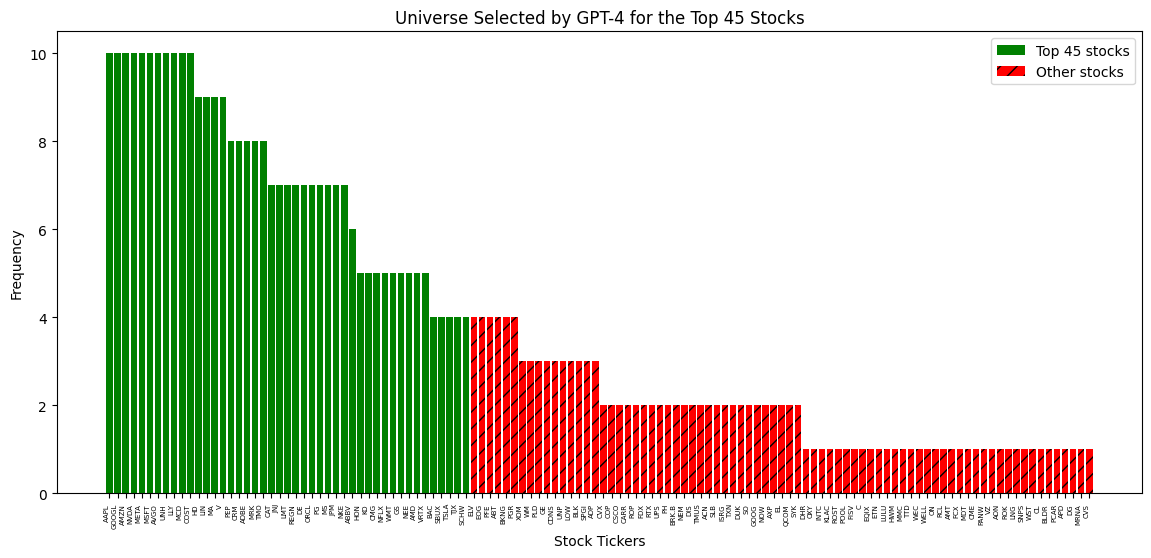

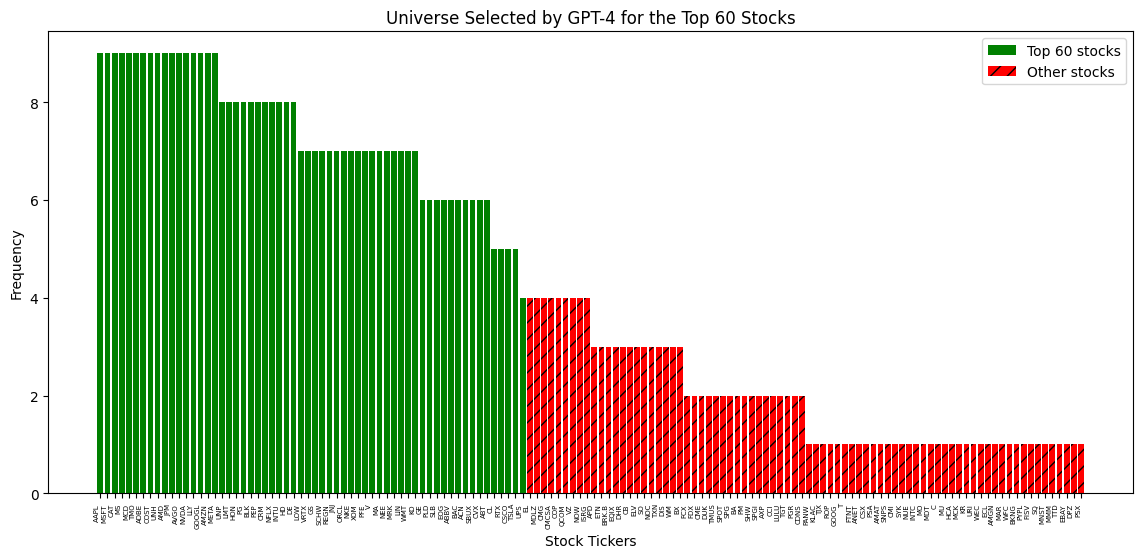

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

for i in choices:
    # Assume df_exploded is your exploded DataFrame with 'ticker' column
    df = df_exploded[df_exploded["n"] == i]
    ticker_counts = df['ticker'].value_counts()

    # Customize top N
    top_n = i
    top_tickers = ticker_counts.head(top_n)
    other_tickers = ticker_counts.iloc[top_n:]

    # Plot
    plt.figure(figsize=(14, 6))

    # Red bars for top tickers
    plt.bar(top_tickers.index, top_tickers.values, color='green', label=f"Top {i} stocks")

    # Blue bars for others
    plt.bar(other_tickers.index, other_tickers.values, color='red', hatch='//', label='Other stocks')

    plt.xticks(rotation=90, ha="right", fontsize=5)
    plt.xlabel("Stock Tickers")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Universe Selected by GPT-4 for the Top {i} Stocks")

    # Add LaTeX-style figure caption
    # plt.figtext(0.5, -0.1, f"Universe of {i} stocks selected by GPT-4", ha='center', fontsize=12)

    plt.savefig(os.path.join('..',f"figs/top_{i}.png"))

In [14]:
def generate_chatgpt_insight(ticker):
    """Generate a prompt and request from OpenAI about the sentiment of a given company."""

    client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    prompt = (
        f"Given the following stock {ticker}, "
        "please write a report on the current state of the company. "
        "Please be clear on when you collected the most recent data. "
        "What are the key insights of each company? "
        "Please highlight the positives and negatives in an objective way for fair sentiment analysis."
        "Include any information from their financial reports or news."
    )
    try:
        response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"

In [18]:
def process_top_stocks(df, top_values=[15, 30, 45, 60], output_dir="sentiment"):
    """Process top X stocks for each choice and save insights to text files."""
    # Ensure output directory exists
    os.makedirs(f"../data/{output_dir}", exist_ok=True)

    # Collect all top stocks across the specified top values
    unique_stocks = set()
    for top_x in top_values:
        # Get top X stocks for each choice and add to the set
        top_stocks = df.groupby("request")["ticker"].value_counts().groupby(level=0).nlargest(top_x).reset_index(level=0, drop=True)
        unique_stocks.update(top_stocks.index.get_level_values(1))
    
    # Generate insights for each unique stock
    for ticker in tqdm.tqdm(unique_stocks, desc="Generating Insights"):
        file_path = os.path.join(f"../data/{output_dir}", f"{ticker}.txt")
        
        # Check if file already exists to avoid duplicate requests
        if os.path.exists(file_path):
            continue
        
        try:
            insight = generate_chatgpt_insight(ticker)
        except Exception as e:
            insight = f"Error generating insight: {str(e)}"
        
        # Save the insight to the file
        with open(file_path, "w") as file:
            file.write(f"Ticker: {ticker}\n")
            file.write(f"Insight:\n{insight}\n")
    
    print(f"Insights saved in the '{output_dir}' directory.")

process_top_stocks(df_exploded, top_values=[15, 30, 45, 60])

Generating Insights: 100%|██████████| 168/168 [54:09<00:00, 19.34s/it]

Insights saved in the 'sentiment' directory.


In [59]:
def download_stock_data(ticker, output_dir="market", retries=5):
    file_path = os.path.join(f"../data/{output_dir}", f"{ticker}.csv")
    if os.path.exists(file_path):
        return f"{ticker} - Already downloaded."

    attempt = 0
    while attempt < retries:
        try:
            data = yf.download(ticker, start="2010-01-01", end="2025-01-01")
            if data.empty:
                return f"{ticker} - No data available."
            
            # Save the data to file
            data.to_csv(file_path)
            return f"{ticker} - Downloaded successfully."
        
        except yf.YFRateLimitError:
            attempt += 1
            wait_time = 2 ** attempt  # Exponential backoff
            print(f"{ticker} - Rate limited. Retrying in {wait_time}s...")
            time.sleep(wait_time)
        except Exception as e:
            return f"{ticker} - Error: {str(e)}"
    
    return f"{ticker} - Failed after {retries} retries."

In [ ]:
def process_top_stocks_data(df, top_values=[15, 30, 45, 60], output_dir="market"):
    """Process top X stocks for each choice and save insights to text files."""
    # Ensure output directory exists
    os.makedirs(f"../data/{output_dir}", exist_ok=True)

    # Collect all top stocks across the specified top values
    unique_stocks = set()
    for top_x in top_values:
        # Get top X stocks for each choice and add to the set
        top_stocks = df.groupby("request")["ticker"].value_counts().groupby(level=0).nlargest(top_x).reset_index(level=0, drop=True)
        unique_stocks.update(top_stocks.index.get_level_values(1))
    
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = {executor.submit(download_stock_data, ticker, output_dir): ticker for ticker in unique_stocks}
        
        for future in tqdm.tqdm(as_completed(futures), total=len(futures), desc="Downloading data"):
            ticker = futures[future]
            try:
                result = future.result()
                print(result)
            except Exception as e:
                print(f"{ticker} - Unexpected Error: {str(e)}")

process_top_stocks_data(df_exploded, top_values=[15, 30, 45, 60])

['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMAT', 'AMD', 'AMGN', 'AMT', 'AMZN', 'ANET', 'ANTM', 'AON', 'APD', 'AVGO', 'AXP', 'BA', 'BAC', 'BKNG', 'BLDR', 'BLK', 'BRK.B', 'BX', 'C', 'CARR', 'CAT', 'CB', 'CCI', 'CDNS', 'CHTR', 'CL', 'CMCSA', 'CME', 'CMG', 'CMI', 'COP', 'COST', 'CRM', 'CROX', 'CSCO', 'CSX', 'CVS', 'CVX', 'DE', 'DG', 'DHR', 'DIS', 'DPZ', 'DRI', 'DUK', 'EBAY', 'ECL', 'EL', 'ELV', 'EOG', 'EQIX', 'ETN', 'EW', 'FCX', 'FDX', 'FISV', 'FTNT', 'GE', 'GOOG', 'GOOGL', 'GS', 'HCA', 'HD', 'HON', 'HWM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KLAC', 'KO', 'KR', 'LIN', 'LLY', 'LMT', 'LNG', 'LOW', 'LRCX', 'LULU', 'MA', 'MAR', 'MCD', 'MCK', 'MDLZ', 'MDT', 'META', 'MMC', 'MMM', 'MNST', 'MO', 'MRK', 'MRNA', 'MS', 'MSCI', 'MSFT', 'MU', 'NEE', 'NEM', 'NFLX', 'NKE', 'NOC', 'NOW', 'NUE', 'NVDA', 'ON', 'ORCL', 'ORLY', 'OXY', 'PANW', 'PCAR', 'PEP', 'PFE', 'PG', 'PGR', 'PH', 'PLD', 'PM', 'POOL', 'PSA', 'PSX', 'PYPL', 'QCOM', 'RCL', 'REGN', 'ROK', 'ROP', 'ROST', 'RTX', 'SBUX', 'SCHW', 'SHW', 'SL

In [47]:
def generate_chatgpt_allocation(stocks):
    """Generates a theoretical model portfolio insight for the given stocks using ChatGPT."""

    client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    
    prompt = (
        f"Assume you're designing a theoretical model portfolio from these S&P500 stocks: {', '.join(stocks)}. "
        "Provide an example of how you might distribute the weightage of these stocks (normalized, i.e., weights should add up to 1.00) in the portfolio "
        "to potentially outperform the S&P500 index. Also mention the underlying strategy or logic which you used to assign these weights. "
        "Please provide any additional rationale when deciding the allocation."
    )
    
    try:
        response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"

In [58]:
def save_chatgpt_responses(df, top_values=[15, 30, 45, 60], output_dir="chatgpt_responses"):
    os.makedirs(f"../data/{output_dir}", exist_ok=True)
    
    # Collect top X stocks for each specified value
    for n in top_values:
        df_filtered = df[df['request'].str.contains(f"N={n}")]
        top_n_stocks = df_filtered['ticker'].value_counts().head(n).index.tolist()

        response = generate_chatgpt_allocation(list(top_n_stocks))

        # Save the response to a text file
        file_path = os.path.join(f"../data/{output_dir}", f"top_{n}_stocks_portfolio.txt")
        with open(file_path, "w") as file:
            file.write(f"Top {n} Stocks: {', '.join(top_n_stocks)}\n\n")
            file.write(response)
        
    print(f"ChatGPT responses saved in the '{output_dir}' directory.")
save_chatgpt_responses(df_exploded)

ChatGPT responses saved in the 'chatgpt_responses' directory.
ChatGPT responses saved in the 'chatgpt_responses' directory.
ChatGPT responses saved in the 'chatgpt_responses' directory.
ChatGPT responses saved in the 'chatgpt_responses' directory.


In [88]:
df_exploded

,request,n,ticker,count
0,N=15 | Request 1,15,AAPL,15
0,N=15 | Request 1,15,MSFT,15
0,N=15 | Request 1,15,GOOGL,15
0,N=15 | Request 1,15,V,15
0,N=15 | Request 1,15,UNH,15
...,...,...,...,...
38,N=60 | Request 9,60,CCI,75
38,N=60 | Request 9,60,LIN,75
38,N=60 | Request 9,60,SHW,75
38,N=60 | Request 9,60,APD,75


In [ ]:
csv_directory = "../data/market" 

# Define the n values for the four groups
n_values = [15, 30, 45, 60]

def plot_top_n_stocks(df, csv_directory, n_values):
    for n in n_values:
        os.makedirs(f"../figs/stock_price", exist_ok=True)
        df_filtered = df[df['request'].str.contains(f"N={n}")]
        
        # Calculate the top N stocks for this group
        top_n_stocks = df_filtered['ticker'].value_counts().head(n).index.tolist()

        plt.figure(figsize=(14, 8))
        plotted_stocks = 0  # Counter for successfully plotted stocks

        for ticker in top_n_stocks:
            csv_path = os.path.join(csv_directory, f"{ticker}.csv")
            if os.path.exists(csv_path):
                stock_data = pd.read_csv(
                    csv_path, 
                    skiprows=2,  # Skip multi-header rows
                    names=["Date", "Close", "High", "Low", "Open", "Volume"],
                    dtype={
                        "Date": str, 
                        "Close": float, 
                        "High": float, 
                        "Low": float, 
                        "Open": float, 
                        "Volume": float
                    },
                    na_values=["", "NaN", "N/A", "null"]
                )

                # Dropping rows with invalid dates or NaN values in essential columns
                stock_data = stock_data.dropna(subset=["Date", "Close"])

                # Converting Date column to datetime (safely)
                stock_data["Date"] = pd.to_datetime(stock_data["Date"], errors="coerce")
                stock_data = stock_data.dropna(subset=["Date"])  # Drop any rows with invalid dates

                # Setting Date as index
                stock_data.set_index("Date", inplace=True)
                if 'Close' in stock_data.columns:
                    plt.plot(stock_data['Close'], label=ticker)
                    plotted_stocks += 1
     
        if plotted_stocks > 0:
            plt.title(f"Top {n} Stocks - Price vs Time")
            plt.xlabel("Date")
            plt.ylabel("Stock Price (USD)")
            if n==60 or n==45:
                plt.legend(loc="upper left", fontsize=8, ncol=2)
            else:
                plt.legend(loc="upper left", fontsize=8)
            plt.tight_layout()
            plt.savefig(f"../figs/stock_price/top_{n}.png")
        else:
            print(f"No valid data for Top {n} Stocks.\n")

# Call the function
plot_top_n_stocks(df_exploded, csv_directory, n_values)

### Pure MVO

In [190]:
def calculate_returns_df(n):
    df_filtered = df_exploded[df_exploded['request'].str.contains(f"N={n}")]
    
    top_n_stocks = df_filtered['ticker'].value_counts().head(n).index.tolist()

    stock_data = {}

    for ticker in top_n_stocks:
        file_name =  f"../data/market/{ticker}.csv"
        try:
            df_raw = pd.read_csv(file_name, skiprows=[1, 2])
            
            if ticker == "UNH":
                df_raw = df_raw.iloc[:, [0, 2, 5, 8, 11, 14]]
            else:
                df_raw = df_raw.iloc[:, :6]
        
            df_raw.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
            df_raw.dropna(how="all", inplace=True) 

            # Converting the Date column to datetime format
            df_raw["Date"] = pd.to_datetime(df_raw["Date"], errors="coerce")

            # Converting the Close column to float 
            df_raw["Close"] = pd.to_numeric(df_raw["Close"], errors="coerce")

            df_clean = df_raw.set_index("Date")
            df_clean["Returns"] = df_clean["Close"].pct_change(fill_method=None) * 100
            stock_data[ticker] = df_clean["Returns"]
        except Exception as e:
            print(ticker, e)

    returns_df = pd.DataFrame()

    for stock, df in stock_data.items():
        returns_df[stock] = df

    return returns_df

In [191]:
top_15_returns = calculate_returns_df(15)
top_30_returns = calculate_returns_df(30)
top_45_returns = calculate_returns_df(45)
top_60_returns = calculate_returns_df(60)

NFLX [Errno 2] No such file or directory: '../data/market/NFLX.csv'
NEE [Errno 2] No such file or directory: '../data/market/NEE.csv'
NFLX [Errno 2] No such file or directory: '../data/market/NFLX.csv'
NEE [Errno 2] No such file or directory: '../data/market/NEE.csv'
GE [Errno 2] No such file or directory: '../data/market/GE.csv'
EOG [Errno 2] No such file or directory: '../data/market/EOG.csv'


In [192]:
top_60_returns.head()

,AAPL,MSFT,CAT,MS,MCD,TMO,ADBE,COST,UNH,AMD,...,BAC,ACN,SBUX,CVX,ABT,CL,RTX,CSCO,TSLA,UPS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.172904,0.032292,3.250451,0.363018,-1.209644,-1.493794,0.172904,0.959388,-2.015035,-0.807937,...,0.589989,0.172904,1.034214,-0.081797,0.172904,0.583531,1.458425,-1.355334,-0.684221,0.939466
2010-01-06,-1.590641,-0.613689,1.172847,-4.072984,-0.035540,-0.524380,-1.590641,-1.425362,1.411915,0.555379,...,-1.811563,-1.590641,-3.224203,-0.678092,-1.590641,1.812934,-0.893573,-0.716841,-1.122703,1.538460
2010-01-07,-0.184866,-1.039996,3.294719,0.213139,-0.248525,0.427405,-0.184866,-1.648915,-0.423754,0.828401,...,-1.701326,-0.184866,-0.634644,0.123593,-0.184866,0.356129,0.823205,2.105893,1.303179,3.348269
2010-01-08,0.664799,0.689662,-0.886028,-0.588897,-1.850856,0.198617,0.664799,0.490072,-0.212767,0.511251,...,2.707694,0.664799,-0.744992,2.671724,0.664799,-0.283912,-0.272137,-0.294654,-2.394563,0.307701


### 1. Equally Weighted Portfolio

In [225]:
os.makedirs('../figs/backtests/equal', exist_ok=True)

def compute_metrics(returns, n):
	# Ensure returns are in decimal form and handle NaN values
    returns = returns / 100  # Convert percentage to decimal
    returns.fillna(0, inplace=True)  # Replace NaN with 0 (no change in price)

    # Calculate the equally weighted portfolio returns
    equal_weights = 1 / returns.shape[1]
    portfolio_returns = (returns * equal_weights).mean(axis=1)

    # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # Plot the cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Equally Weighted Portfolio')
    plt.title(f"Equally Weighted Portfolio Backtest n={n}")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.savefig(f'../figs/backtests/equal/top_{n}.png')

    # Performance Metrics
    total_return = cumulative_returns.iloc[-1] - 1
    annualized_return = (cumulative_returns.iloc[-1]) ** (252 / len(cumulative_returns)) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    # Display metrics
    print(f'Total Return: {total_return:.2%}')
    print(f'Annualized Return: {annualized_return:.2%}')
    print(f'Annualized Volatility: {annualized_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

Total Return: 18.04%
Annualized Return: 1.11%
Annualized Volatility: 1.17%
Sharpe Ratio: 0.95


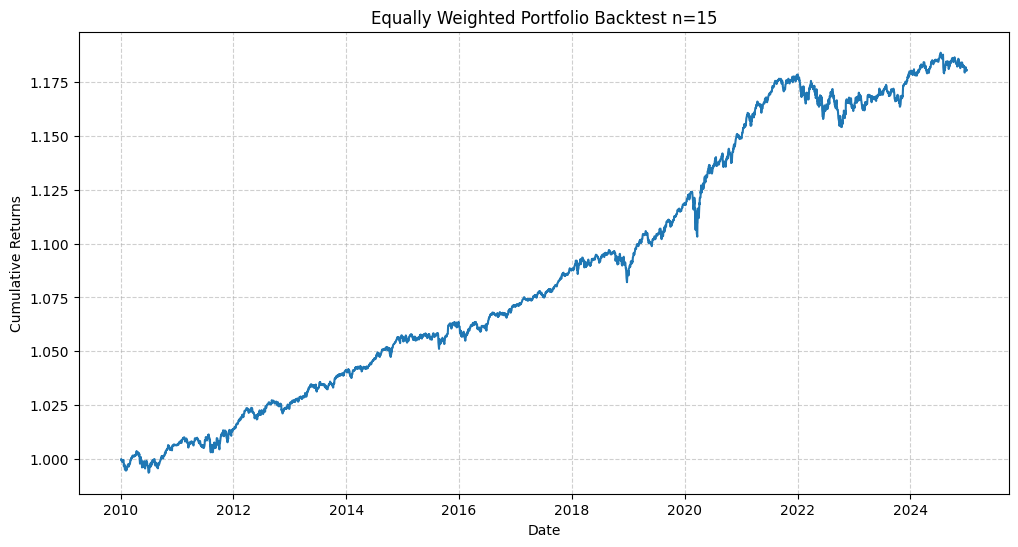

In [226]:
compute_metrics(top_15_returns, 15)

Total Return: 10.16%
Annualized Return: 0.65%
Annualized Volatility: 0.57%
Sharpe Ratio: 1.14


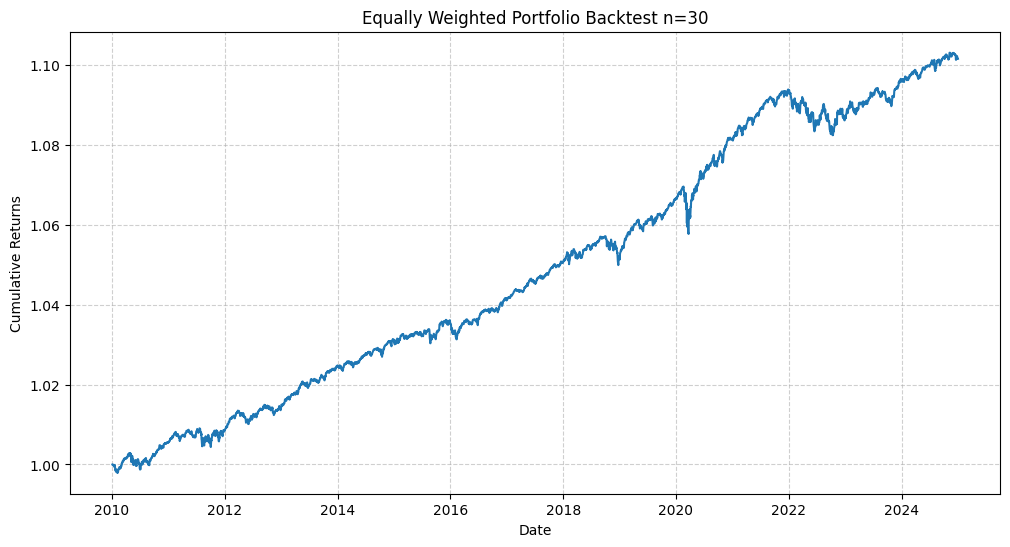

In [228]:
compute_metrics(top_30_returns, 30)

Total Return: 6.84%
Annualized Return: 0.44%
Annualized Volatility: 0.40%
Sharpe Ratio: 1.10


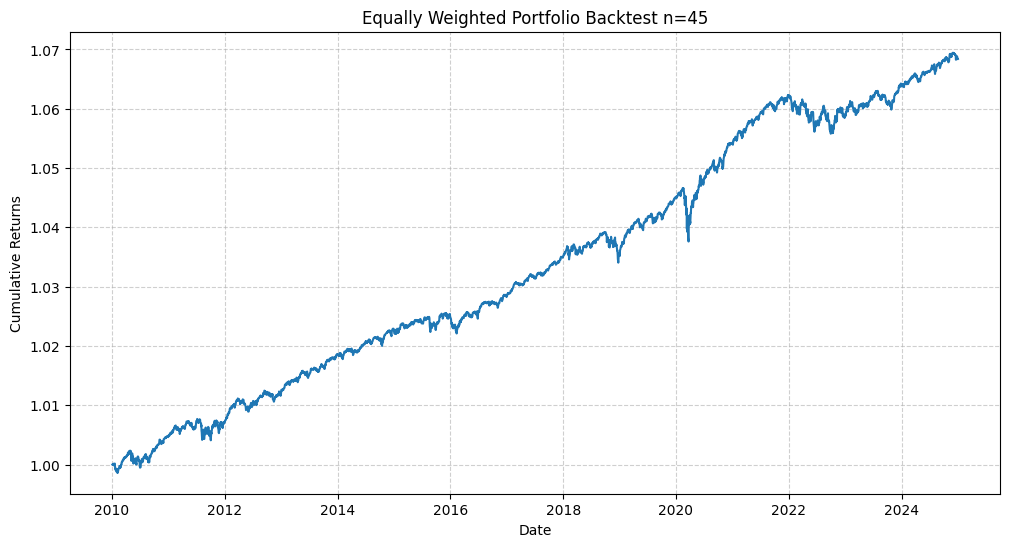

In [229]:
compute_metrics(top_45_returns, 45)

Total Return: 5.60%
Annualized Return: 0.36%
Annualized Volatility: 0.32%
Sharpe Ratio: 1.15


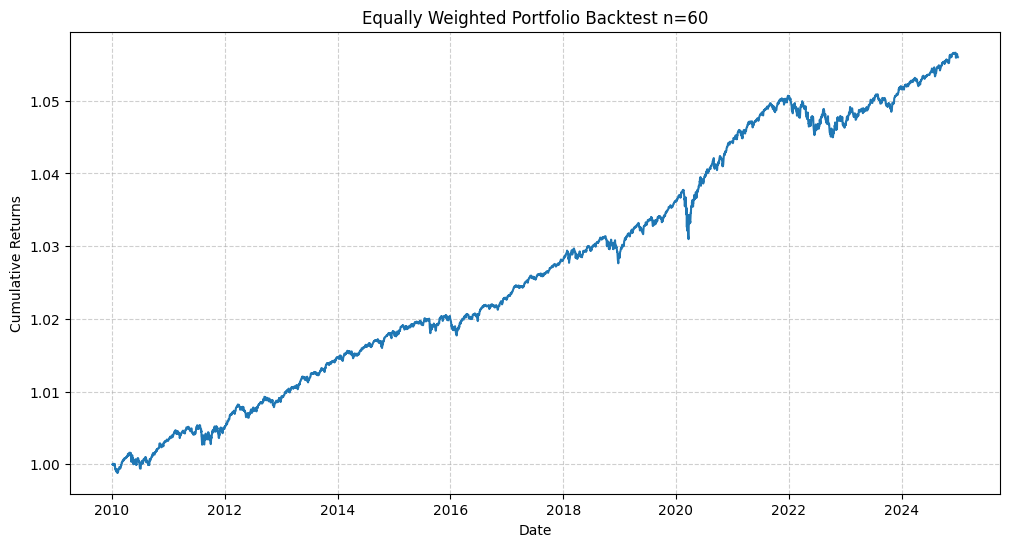

In [230]:
compute_metrics(top_60_returns, 60)

In [186]:
r = 0.08

w = cp.Variable(15)
objective = cp.Minimize(cp.quad_form(w, sigma))
constraints = [
    cp.sum(w) == 1,           
    w @ mu >= r,
	w >= 0,      
]

problem = cp.Problem(objective, constraints)

try:
    problem.solve(solver = cp.CLARABEL)
    print ("Optimal portfolio")
    print ("----------------------")
    for s in range(len(mu)):
        print (" Investment in {} : {}% of the portfolio".format(s + 1,round(100*w.value[s],2)))
    print ("----------------------")
    print (f"Expected return = {(w.value @ mu)}%")
    print (f"Expected risk = {np.sqrt(w.value.T @ sigma @ w.value)}%")
except Exception as e:
    print(e)

Optimal portfolio
----------------------
 Investment in 1 : 20.36% of the portfolio
 Investment in 2 : 0.0% of the portfolio
 Investment in 3 : 1.28% of the portfolio
 Investment in 4 : 2.83% of the portfolio
 Investment in 5 : 21.92% of the portfolio
 Investment in 6 : 4.76% of the portfolio
 Investment in 7 : 6.41% of the portfolio
 Investment in 8 : 7.63% of the portfolio
 Investment in 9 : 1.77% of the portfolio
 Investment in 10 : 0.0% of the portfolio
 Investment in 11 : 28.16% of the portfolio
 Investment in 12 : 3.34% of the portfolio
 Investment in 13 : 0.0% of the portfolio
 Investment in 14 : 1.54% of the portfolio
 Investment in 15 : 0.0% of the portfolio
----------------------
Expected return = 0.08000000003963118%
Expected risk = 1.0333984251818915%
